In [1]:
import openeo
from generate import create_ppi_cube

In [2]:

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [3]:
spatial_extent = {
    "west": 4.22,
    "south": 51.16,
    "east": 4.377856,
    "north": 51.26
}
geom = {
    "type": "Polygon",
    "coordinates": [[
        [spatial_extent["west"], spatial_extent["south"]],
        [spatial_extent["east"], spatial_extent["south"]],
        [spatial_extent["east"], spatial_extent["north"]],
        [spatial_extent["west"], spatial_extent["north"]],
        [spatial_extent["west"], spatial_extent["south"]]
    ]]
}

temporal_extent = ["2024-06-01", "2024-08-30"]
ppi_cube = create_ppi_cube(
    connection=connection,
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
    geom=geom
)
job = ppi_cube.create_job(out_format="GTiff", title="ppi_example").start_and_wait()


0:00:00 Job 'j-2601261429344a71bcaf6eff0c974358': send 'start'
0:00:14 Job 'j-2601261429344a71bcaf6eff0c974358': created (progress 0%)
0:00:19 Job 'j-2601261429344a71bcaf6eff0c974358': created (progress 0%)
0:00:26 Job 'j-2601261429344a71bcaf6eff0c974358': created (progress 0%)
0:00:34 Job 'j-2601261429344a71bcaf6eff0c974358': created (progress 0%)
0:00:43 Job 'j-2601261429344a71bcaf6eff0c974358': queued (progress 0%)
0:00:56 Job 'j-2601261429344a71bcaf6eff0c974358': queued (progress 0%)
0:01:11 Job 'j-2601261429344a71bcaf6eff0c974358': queued (progress 0%)
0:01:30 Job 'j-2601261429344a71bcaf6eff0c974358': queued (progress 0%)
0:01:54 Job 'j-2601261429344a71bcaf6eff0c974358': queued (progress 0%)
0:02:24 Job 'j-2601261429344a71bcaf6eff0c974358': queued (progress 0%)
0:03:02 Job 'j-2601261429344a71bcaf6eff0c974358': running (progress N/A)
0:03:48 Job 'j-2601261429344a71bcaf6eff0c974358': running (progress N/A)
0:04:47 Job 'j-2601261429344a71bcaf6eff0c974358': running (progress N/A)
0:05

In [4]:
from pathlib import Path

result_folder = Path("results5")
result_folder.mkdir(exist_ok=True)

job.download_results(result_folder)

C:\Users\VROMPAYH\AppData\Local\Temp\ipykernel_36632\3977425874.py:6: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(result_folder)
c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\py311\Lib\site-packages\openeo\rest\job.py:192: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\py311\Lib\site-packages\openeo\rest\job.py:196: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


{WindowsPath('results5/openEO_2024-06-05Z.tif'): {'eo:bands': [{'name': 'PPI'}],
  'href': 'https://s3.waw3-1.openeo.v1.dataspace.copernicus.eu/openeo-data-prod-waw4-1/batch_jobs/j-2601261429344a71bcaf6eff0c974358/openEO_2024-06-05Z.tif?X-Proxy-Head-As-Get=true&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=8eae3aa21fcb4e9a8b34e98cf2feecbd%2F20260126%2Fwaw4-1%2Fs3%2Faws4_request&X-Amz-Date=20260126T143523Z&X-Amz-Expires=86400&X-Amz-SignedHeaders=host&X-Amz-Security-Token=eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCJ9.eyJyb2xlX2FybiI6ImFybjpvcGVuZW93czppYW06Ojpyb2xlL29wZW5lby1kYXRhLXByb2Qtd2F3NC0xLXdvcmtzcGFjZSIsImluaXRpYWxfaXNzdWVyIjoib3BlbmVvLnByb2Qud2F3My0xLm9wZW5lby1pbnQudjEuZGF0YXNwYWNlLmNvcGVybmljdXMuZXUiLCJodHRwczovL2F3cy5hbWF6b24uY29tL3RhZ3MiOnsicHJpbmNpcGFsX3RhZ3MiOnsiam9iX2lkIjpbImotMjYwMTI2MTQyOTM0NGE3MWJjYWY2ZWZmMGM5NzQzNTgiXSwidXNlcl9pZCI6WyJhNDIxZjg0OS0yYWU2LTQyZDMtOTNmMC1iNDNhYTI1NjdmMWUiXX0sInRyYW5zaXRpdmVfdGFnX2tleXMiOlsidXNlcl9pZCIsImpvYl9pZCJdfSwiaXNzIjoic3RzLndhdzMtMS5vcGVu

Band 1: min=0.0000, max=3.0000


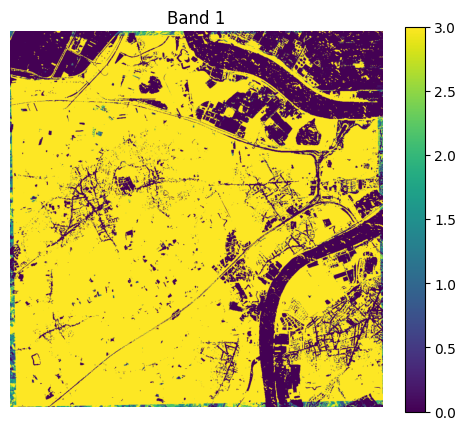

Band 2: min=0.0000, max=1.0000


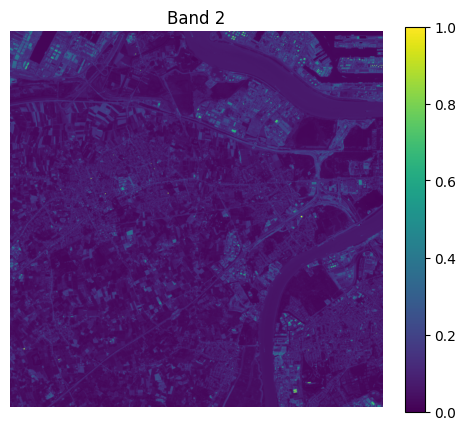

Band 3: min=0.0000, max=1.0000


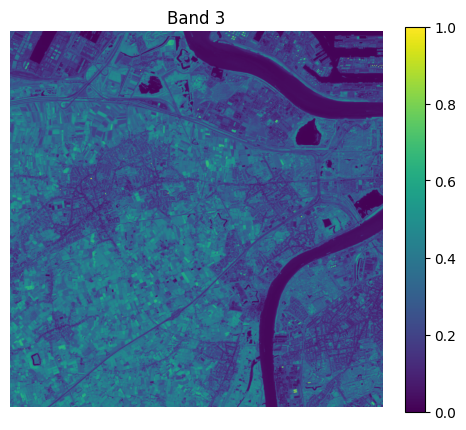

Band 4: min=-0.8480, max=0.9200


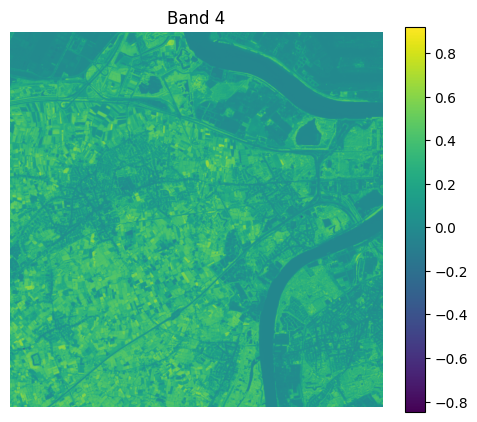

Band 5: min=-0.4284, max=0.7204


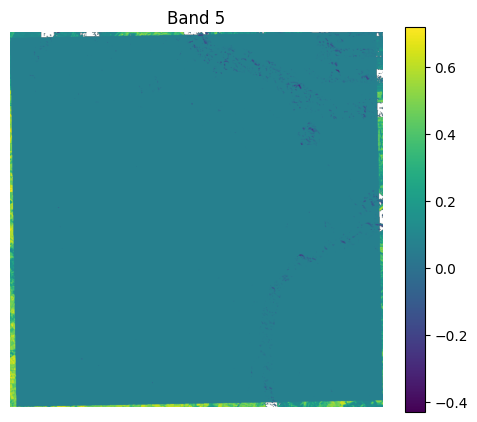

Band 6: min=-0.3427, max=0.0734


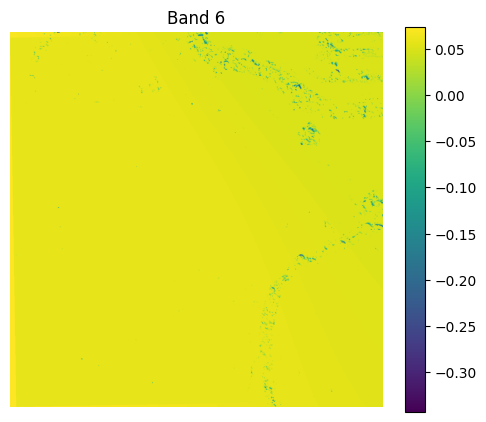

Band 7: min=0.5231, max=2.0000


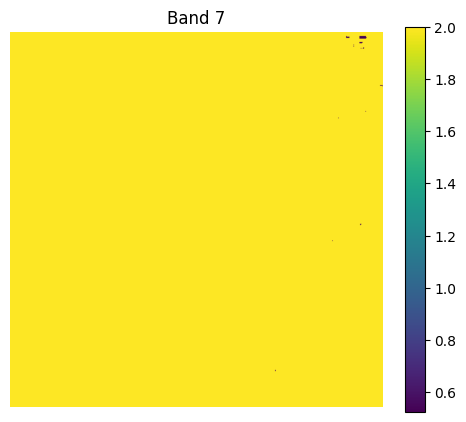

Band 8: min=-420.6000, max=62.9235


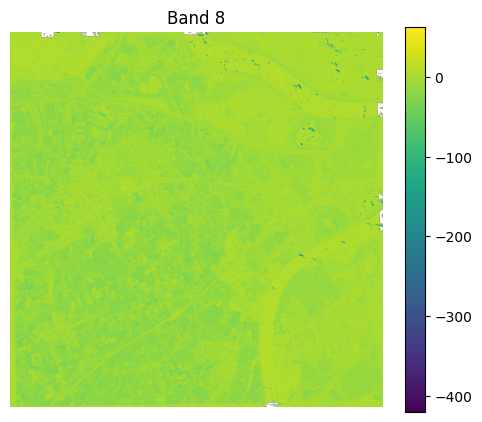

Band 9: min=37.7514, max=37.7514


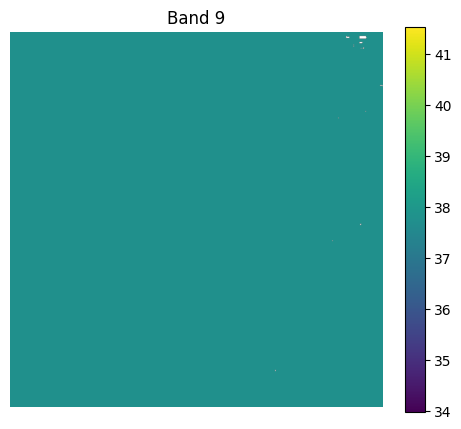

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

tif_path = r"C:\Git_projects\apex_algorithms\algorithm_catalog\vito\ppi\openeo_udp\results5\openEO_2024-08-12Z.tif"

with rasterio.open(tif_path) as src:
    for i in range(1, src.count + 1):
        band = src.read(i).astype(float)

        # remove NaN and infinity
        band[~np.isfinite(band)] = np.nan

        # compute inherent scale safely
        vmin = np.nanmin(band)
        vmax = np.nanmax(band)

        print(f"Band {i}: min={vmin:.4f}, max={vmax:.4f}")

        plt.figure(figsize=(6,5))
        im = plt.imshow(band, vmin=vmin, vmax=vmax, cmap="viridis")
        plt.colorbar(im)
        plt.title(f"Band {i}")
        plt.axis("off")
        plt.show()
